<a href="https://colab.research.google.com/github/GustavoHDLC1/Colab_Files_PADP/blob/main/Sem13_Practica26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Enlace GitHub](https://github.com/GustavoHDLC1/Colab_Files_PADP/blob/main/Sem13_Practica26.ipynb)

In [ ]:
pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import export_text

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759)

# data (as pandas dataframes)
X = glioma_grading_clinical_and_mutation_features.data.features
y = glioma_grading_clinical_and_mutation_features.data.targets

# metadata
print(glioma_grading_clinical_and_mutation_features.metadata)

# variable information
print(glioma_grading_clinical_and_mutation_features.variables)


{'uci_id': 759, 'name': 'Glioma Grading Clinical and Mutation Features', 'repository_url': 'https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/759/data.csv', 'abstract': 'Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.    In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.  The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading 

In [ ]:
X

,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,51.30,white,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,0,38.72,white,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,35.17,white,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,32.78,white,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,31.51,white,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,77.89,white,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
835,0,85.18,white,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
836,1,77.49,white,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
837,0,63.33,white,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
cols_cat = X.columns.tolist()
cols_cat.remove('Age_at_diagnosis')
cols_num = ['Age_at_diagnosis']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            839 non-null    int64  
 1   Age_at_diagnosis  839 non-null    float64
 2   Race              839 non-null    object 
 3   IDH1              839 non-null    int64  
 4   TP53              839 non-null    int64  
 5   ATRX              839 non-null    int64  
 6   PTEN              839 non-null    int64  
 7   EGFR              839 non-null    int64  
 8   CIC               839 non-null    int64  
 9   MUC16             839 non-null    int64  
 10  PIK3CA            839 non-null    int64  
 11  NF1               839 non-null    int64  
 12  PIK3R1            839 non-null    int64  
 13  FUBP1             839 non-null    int64  
 14  RB1               839 non-null    int64  
 15  NOTCH1            839 non-null    int64  
 16  BCOR              839 non-null    int64  
 1

Comprobamos que no existen valores nulos

## EDA

In [ ]:
X[cols_num].describe()

,Age_at_diagnosis
count,839.000000
mean,50.935411
std,15.702339
min,14.420000
25%,38.055000
50%,51.550000
75%,62.800000
max,89.290000


De acuerdo con el catálogo de las variables, esta es la única variable numérica, por lo que no tiene sentido obtener las estadísticas descriptivas del resto, ya que se trata de categóricas

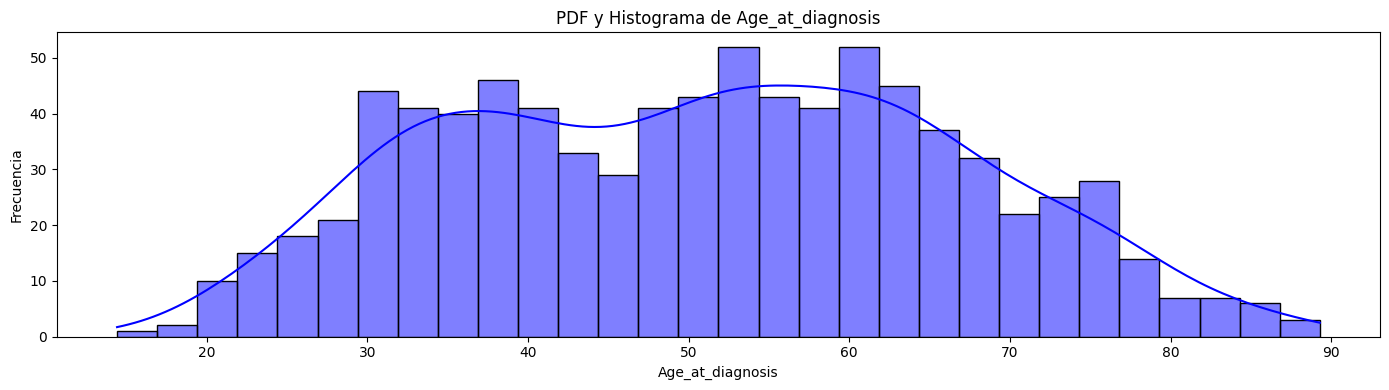

In [ ]:
# Crear los gráficos de PDF e Histograma
plt.figure(figsize=(14, 4))
sns.histplot(X[cols_num[0]], kde=True, bins=30, color='blue')
plt.title(f'PDF y Histograma de {cols_num[0]}', fontsize=12)
plt.xlabel(cols_num[0], fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.tight_layout()
plt.show()

Dado que solo tenemos esta variable categórica, es el único histograma que se puede obtener, en el cual observamos que no existe una distribución normal, sin embargo, es irrelevante ese criterio para nuestro modelo, ya que será un árbol de clasificación, el cual, no requiere de que se cumpla el supuesto de normalidad

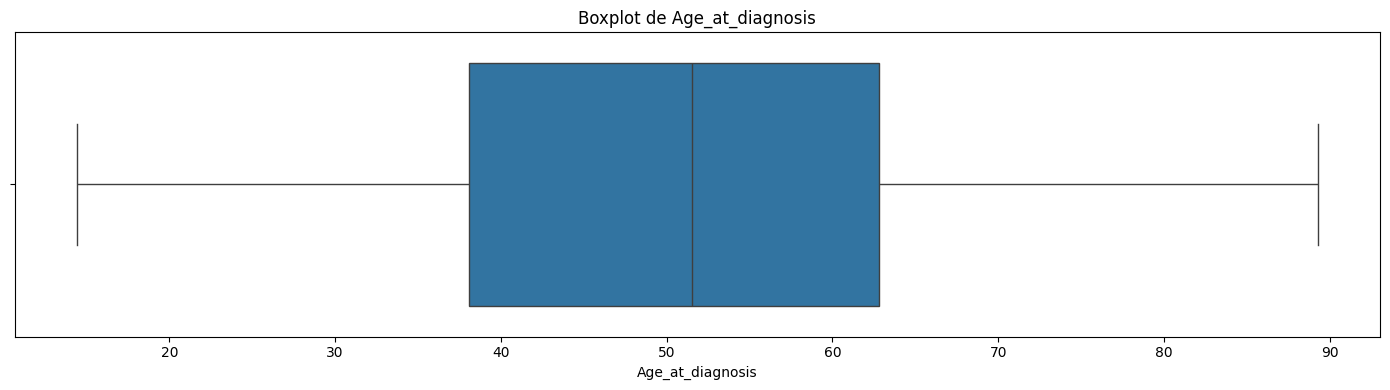

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 4))
# Crear boxplots para cada columna numérica
sns.boxplot(x=X[cols_num[0]])
plt.title(f'Boxplot de {cols_num[0]}')
plt.tight_layout()
plt.show()

En este caso no se observan valores atípicos, por lo que no es necesario aplicar ningún método adicional para esta parte

In [ ]:
len(cols_cat)

22

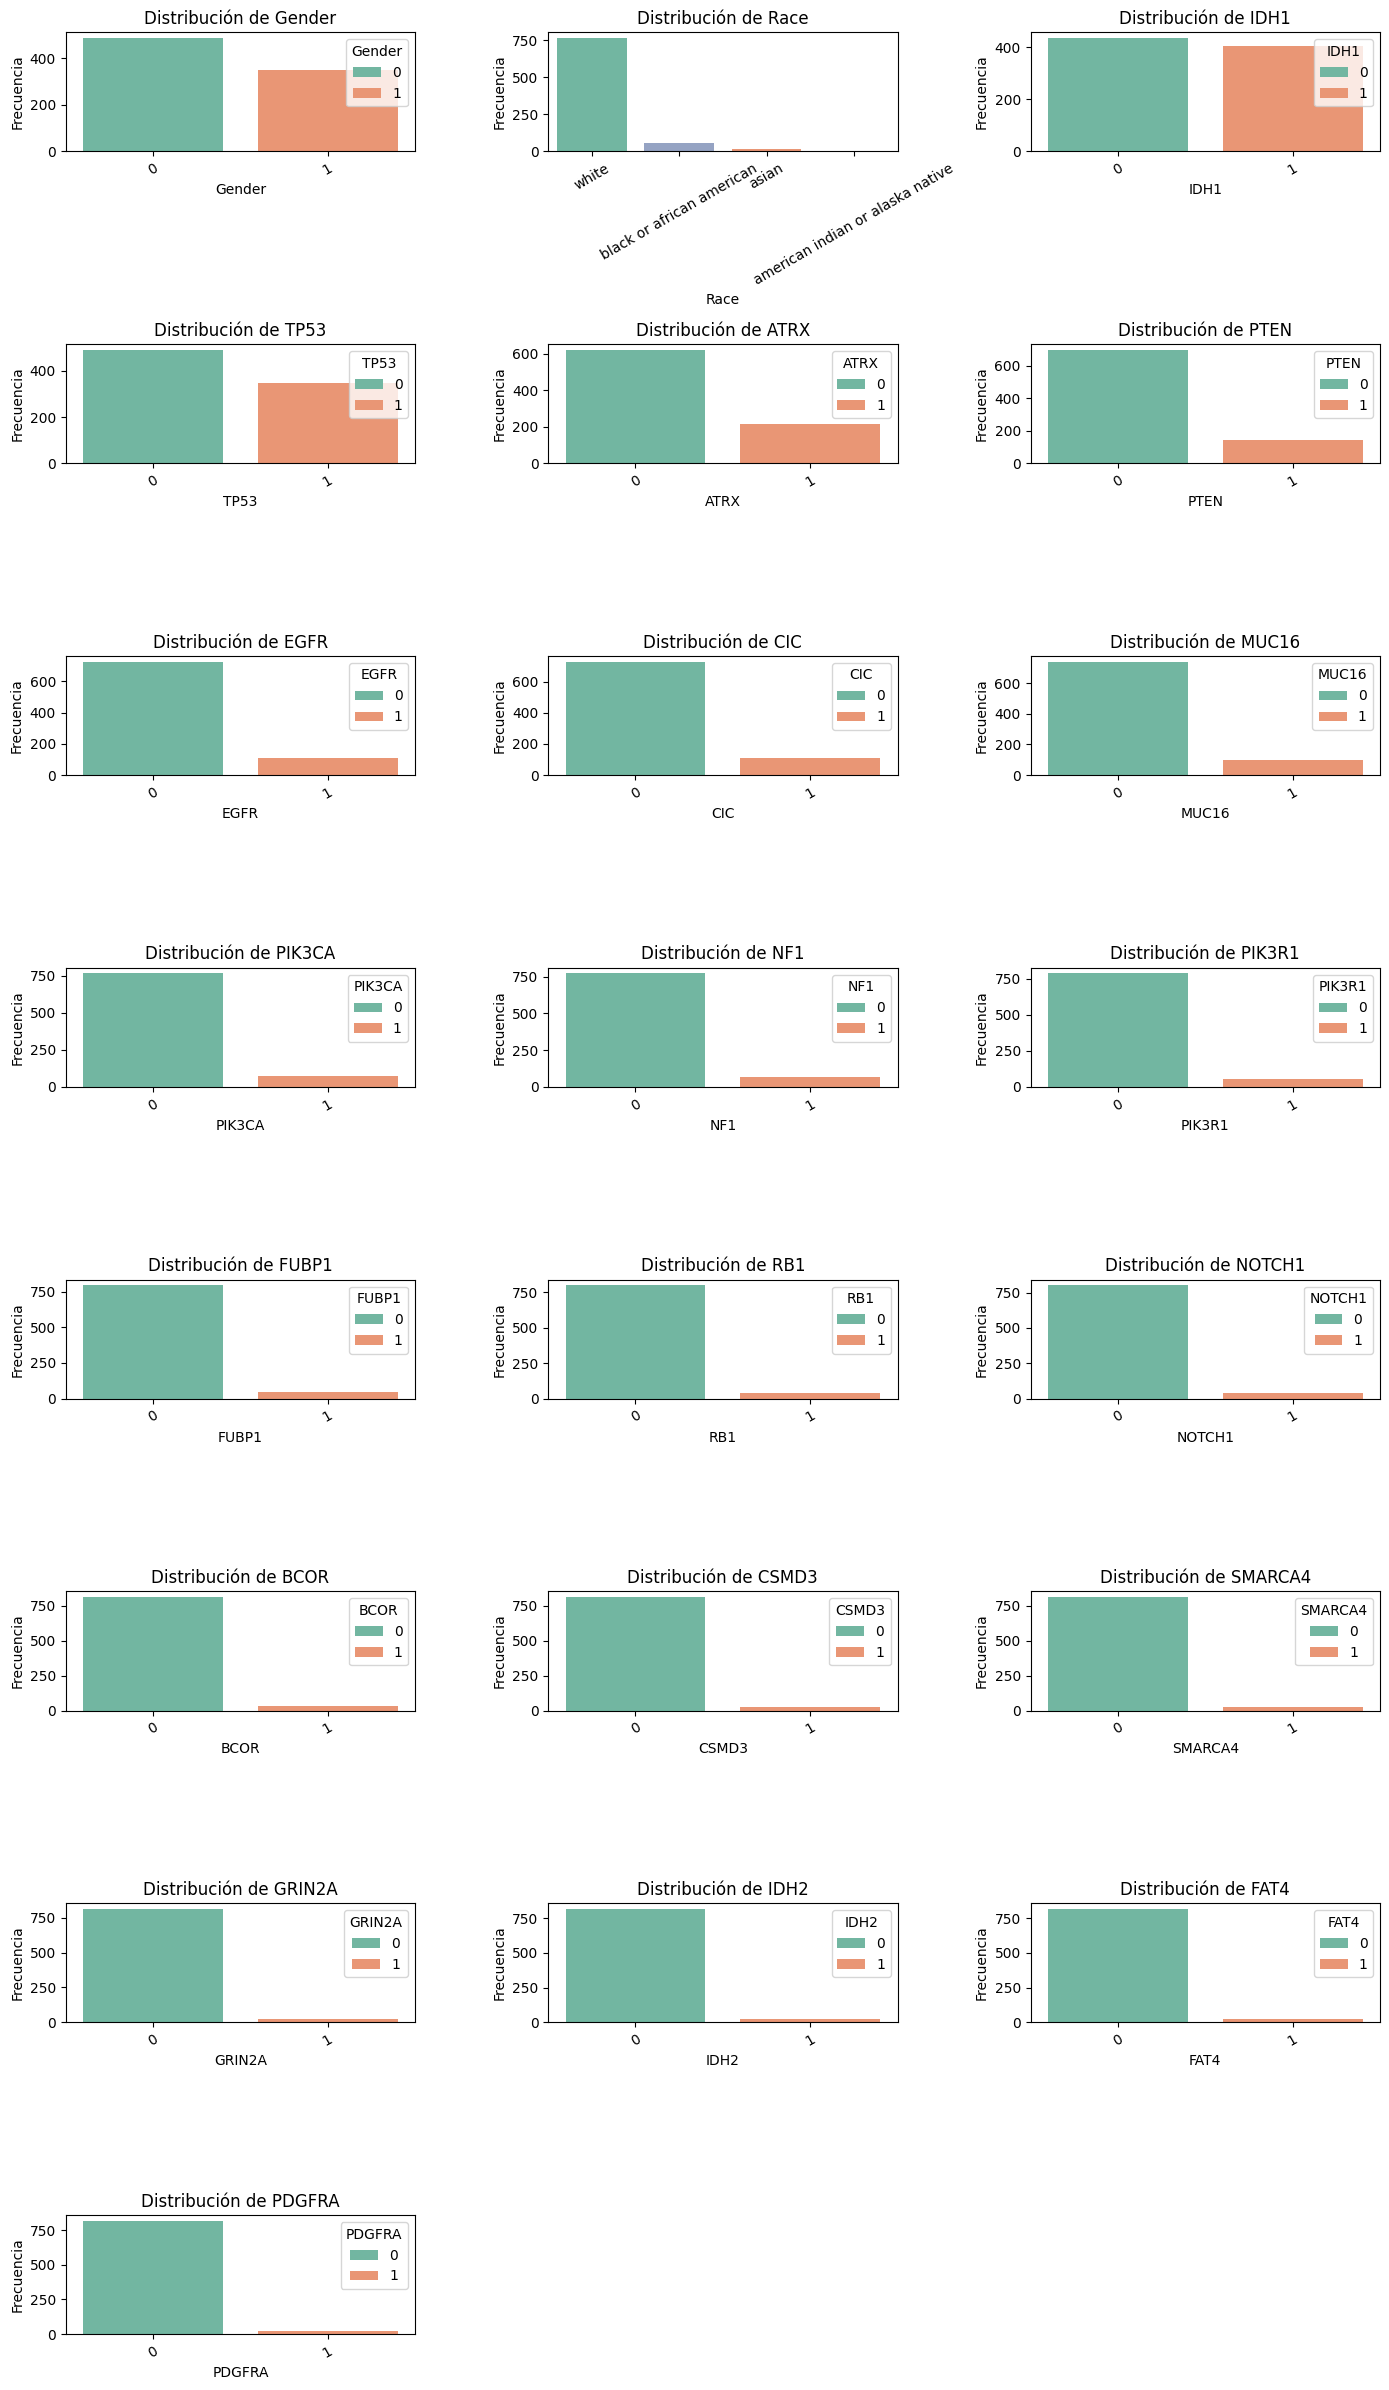

In [ ]:
# Crear gráficos de barras
plt.figure(figsize=(14, 4*6))

for i, col in enumerate(cols_cat, 1):
    plt.subplot(8, 3, i)  # un gráfico por fila
    sns.countplot(data=X, x=col, hue=col, palette="Set2", order=X[col].value_counts().index)

    plt.title(f'Distribución de {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.xticks(rotation=30)  # rotar etiquetas si son largas

plt.tight_layout()
plt.show()

A excepción de la variable "Race", todas las demás son binarias y se observa que estan desbalanceadas.

In [ ]:
y.value_counts()

,count
Grade,
0,487
1,352


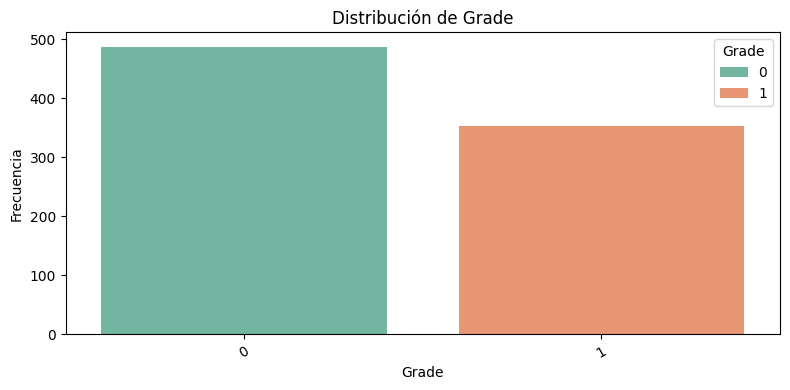

In [ ]:
# Crear gráficos de barras
col = y.columns.tolist()[0]
plt.figure(figsize=(8, 4))
sns.countplot(data=y, x=col, hue=col, palette="Set2", order=y[col].value_counts().index)
plt.title(f'Distribución de {col}', fontsize=12)
plt.xlabel(col, fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(rotation=30)  # rotar etiquetas si son largas

plt.tight_layout()
plt.show()

Para la target, existe un desbalanceo pero no es tan marcado como en las variables predictoras

## Gráfica de Errores en Entrenamiento y Prueba

In [ ]:

# Crear el transformador
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cols_cat)
])
# Aplicar la transformación
df = preprocessor.fit_transform(X)
# Obtener los nombres de las columnas transformadas
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cols_cat)
# Unir todos los nombres
all_features = list(cat_features)
# Crear el DataFrame final
X_pre = pd.DataFrame(df, columns=all_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
depths = [2, 5, 10, 15, 20, 25, 30, None]
# 4. Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=3)

# Listas para guardar resultados
train_scores = []
test_scores = []

# Evaluar cada profundidad
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=7)

    # Exactitud en entrenamiento (usando validación cruzada en el set de entrenamiento)
    cv_train = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro')
    train_scores.append(np.mean(cv_train))

    # Exactitud en test (evaluar en X_test, y_test usando el modelo ajustado con cada fold)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)

    # Evaluar F1 en test (solo una medición por modelo)

    f1_test = f1_score(y_test, y_pred_test, average='macro')
    test_scores.append(f1_test)

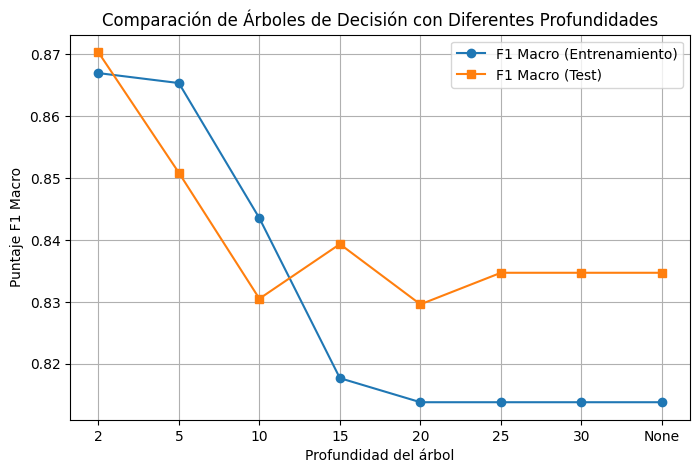

In [ ]:
# --- Gráfica de resultados ---
plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in depths], train_scores, marker='o', label='F1 Macro (Entrenamiento)')
plt.plot([str(d) for d in depths], test_scores, marker='s', label='F1 Macro (Test)')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Puntaje F1 Macro')
plt.title('Comparación de Árboles de Decisión con Diferentes Profundidades')
plt.legend()
plt.grid(True)
plt.show()

## Randomized SearchCV

In [ ]:
from scipy.stats import randint

In [ ]:
# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)) ,
    'min_samples_split': list(range(2, 21))
}

# 4. Stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=5,              # Número de combinaciones aleatorias a probar
    cv=cv,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

# 6. Ajustar el modelo
random_search.fit(X_pre, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor exactitud promedio (Stratified):", random_search.best_score_)

Mejores hiperparámetros encontrados: {'min_samples_split': 17, 'max_depth': 35, 'criterion': 'entropy'}
Mejor exactitud promedio (Stratified): 0.8443799327732551


## GridSearchCV

In [ ]:
# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)) ,
    'min_samples_split': list(range(2, 21))
}

# 4. Stratified
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Configurar GridSearchCV con Strafified
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# 6. Ajustar el modelo
grid_search.fit(X_pre, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor exactitud promedio (Stratified):", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 13}
Mejor exactitud promedio (Stratified): 0.8690272941087537


## RandomizedSearchCV (Accuracy)

In [ ]:
# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)) ,
    'min_samples_split': list(range(2, 21))
}

# 4. Stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=5,              # Número de combinaciones aleatorias a probar
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# 6. Ajustar el modelo
random_search.fit(X_pre, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor exactitud promedio (Stratified):", random_search.best_score_)

Mejores hiperparámetros encontrados: {'min_samples_split': 17, 'max_depth': 35, 'criterion': 'entropy'}
Mejor exactitud promedio (Stratified): 0.8474469305794606


## GridSearchCV (Accuracy)

In [ ]:
# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)) ,
    'min_samples_split': list(range(2, 21))
}

# 4. Stratified
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Configurar GridSearchCV con Strafified
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# 6. Ajustar el modelo
grid_search.fit(X_pre, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor exactitud promedio (Stratified):", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 13}
Mejor exactitud promedio (Stratified): 0.870059880239521


¿Cuál método encontró mejores hiperparámetros?
GridSearchCV con accuracy, pero podría ser engañosa esa métrica ya que tenemos una clase ligeramente desbalanceada

¿Cuál fue más costoso computacionalmente?
GridSearchCV ya que busca todas las combinaciones posibles, mientras que randomized toma n al azar

¿Los resultados en f1_macro set fueron distintos en ambos métodos de optimización? ¿Por qué?
Si, fueron ligeramente mejor en GridSearchCV, esto se debe a la naturaleza del mismo, que prueba todas las combinaciones, por lo que garantiza encontrar la óptima, mientras que con randomized es posible no encontrarla en la muestra seleccionada

¿Los resultados en accuracy set fueron distintos en ambos métodos de optimización? ¿Por qué?
Si, la razón es la misma que en el caso anterior, por la manera en que funcionan los métodos

¿Los valores de hiperpárametros fueron iguales en Accuracy y F1 Macro ?
Si, es decir, para GridSearchCV con ambas métricas se obtuvieron los mismos hiperparámetros, y para Randomized se obtuvieron diferentes a Grid, pero iguales entre si cambiando la métrica

En general los modelos encontrados parecen ser muy buenos ya que las métricas indican un buen rendimiento y no parece haber sobreajuste